# Image postprocessing of PMDI sprays

This program takes images of PMDI sprays and obtains extinction profiles.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 07/05/2020
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate
%matplotlib notebook


In [2]:
# Define where images come from.
source_images = "/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series"
source_bkgnd = "/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/bkgnd.tif"


## Load images
Crop and mask as required, flip so spray is at center-left near X=0.

In [21]:
# Read in images.
B=ImageSequence(source_bkgnd)
I=ImageSequence("/Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/", IO_threads=4)

# Extract intensity reference
refp = I.arr[:,8,351]

# apply crop
B.crop(107,107+304,85,85+915)
I.crop(107,107+304,85,85+915)
print('\nFinal array sizes:', B.shape(), I.shape())

# Mask unwanted portions of image
B.mask_box(268,305,903,916)
B.mask_box(0,42,903,916)

# apply flip
B.fliph()
I.fliph()


Reading /Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/bkgnd.tif
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
Magick: Incorrect count for "ColorMap"; tag ignored. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/1037
Read 1.0 MiB in 0.0 sec
	Data in memory:	 (1, 512, 1024)
	Intensity range:	 0 to 39238 	 uint32
	Array size:	2.0 MB
Reading /Users/dduke/Desktop/ThinBo-1Hole-E05 Example Series/
	Found 801 images with extension .tif
	PythonMagick thinks the bit depth is <class 'numpy.uint16'>
	Increasing stored bit depth from <class 'numpy.uint16'> to <class 'numpy.uint32'>
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  41 out of  41 | elapsed:   13.8s finished


Read 801.0 MiB in 15.4 sec
	Data in memory:	 (801, 512, 1024)
	Intensity range:	 0 to 39781 	 uint32
	Array size:	1602.0 MB

Final array sizes: (1, 305, 916) (801, 305, 916)


In [4]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = B.arr[0,...].astype(np.float32)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd
    
# Convert transmission to extinction
Ib = 1.0 - Ib

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])


<IPython.core.display.Javascript object>


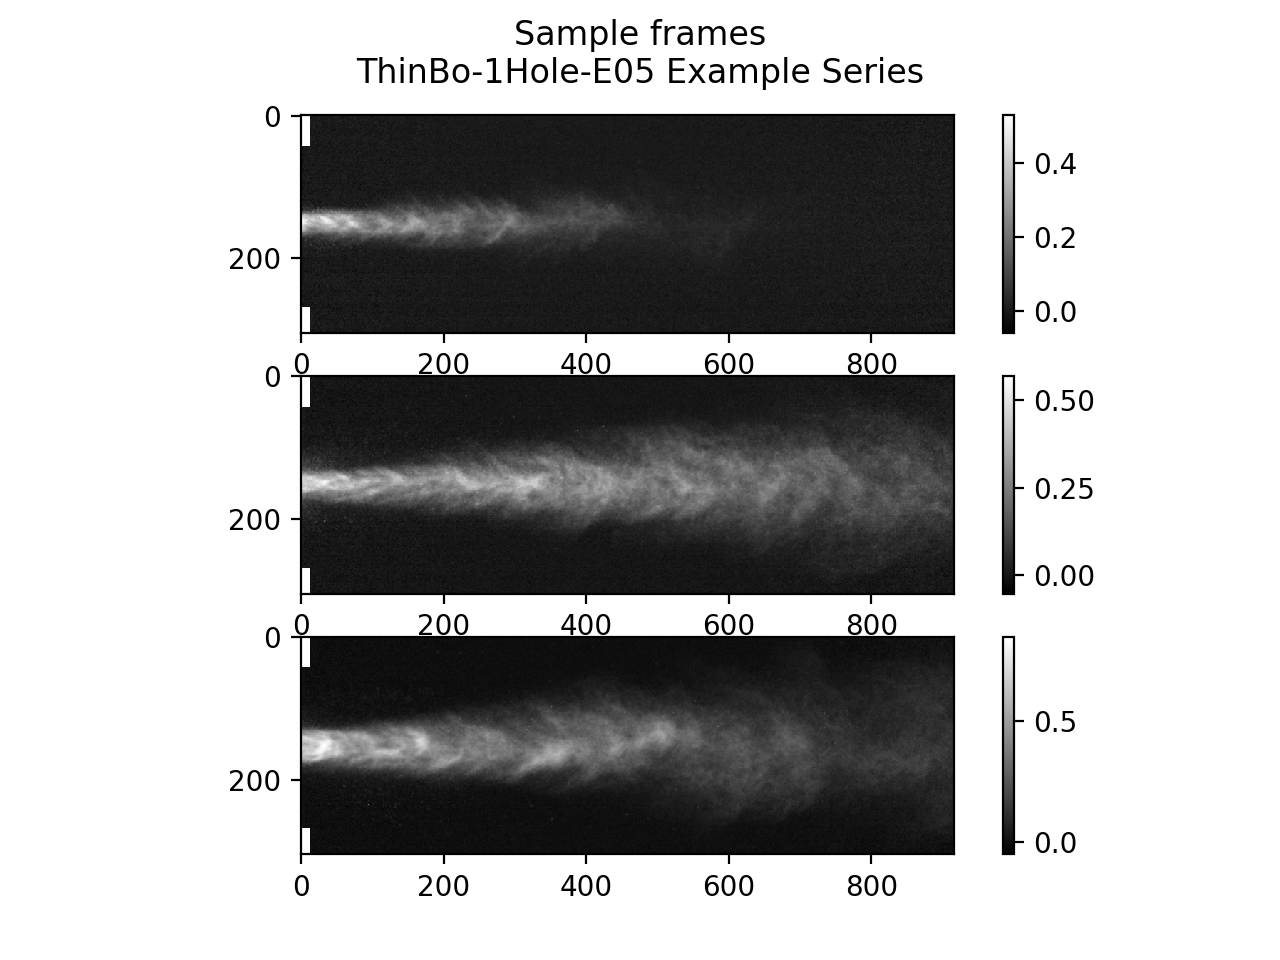

In [5]:
# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(311)
h=ax.imshow(Ib[38,...],cmap=plt.cm.gray)
plt.colorbar(h)
ax=fig.add_subplot(312)
h=ax.imshow(Ib[50,...],cmap=plt.cm.gray)
plt.colorbar(h)
ax=fig.add_subplot(313)
h=ax.imshow(Ib[75,...],cmap=plt.cm.gray)
plt.colorbar(h);


## Find the period of time where the spray is steadiest
Use the spray profile right near the nozzle where extinction signal is strongest to do this.

In [6]:
# Reslice near the nozzle to see time evolution
# Average over several X positions.
near_nozzle_profiles = np.nanmean(Ib[...,10:25],axis=-1).T
near_nozzle_integral = scipy.integrate.simps(near_nozzle_profiles.T,x=y,axis=-1)

# Use the integral to find the spray "on" time
threshold = 0.67 # higher value means less time samples but lower std dev.
on = np.where(near_nozzle_integral > threshold*np.nanmax(near_nozzle_integral))[0]
t0,t1 = on[0],on[-1]


<IPython.core.display.Javascript object>


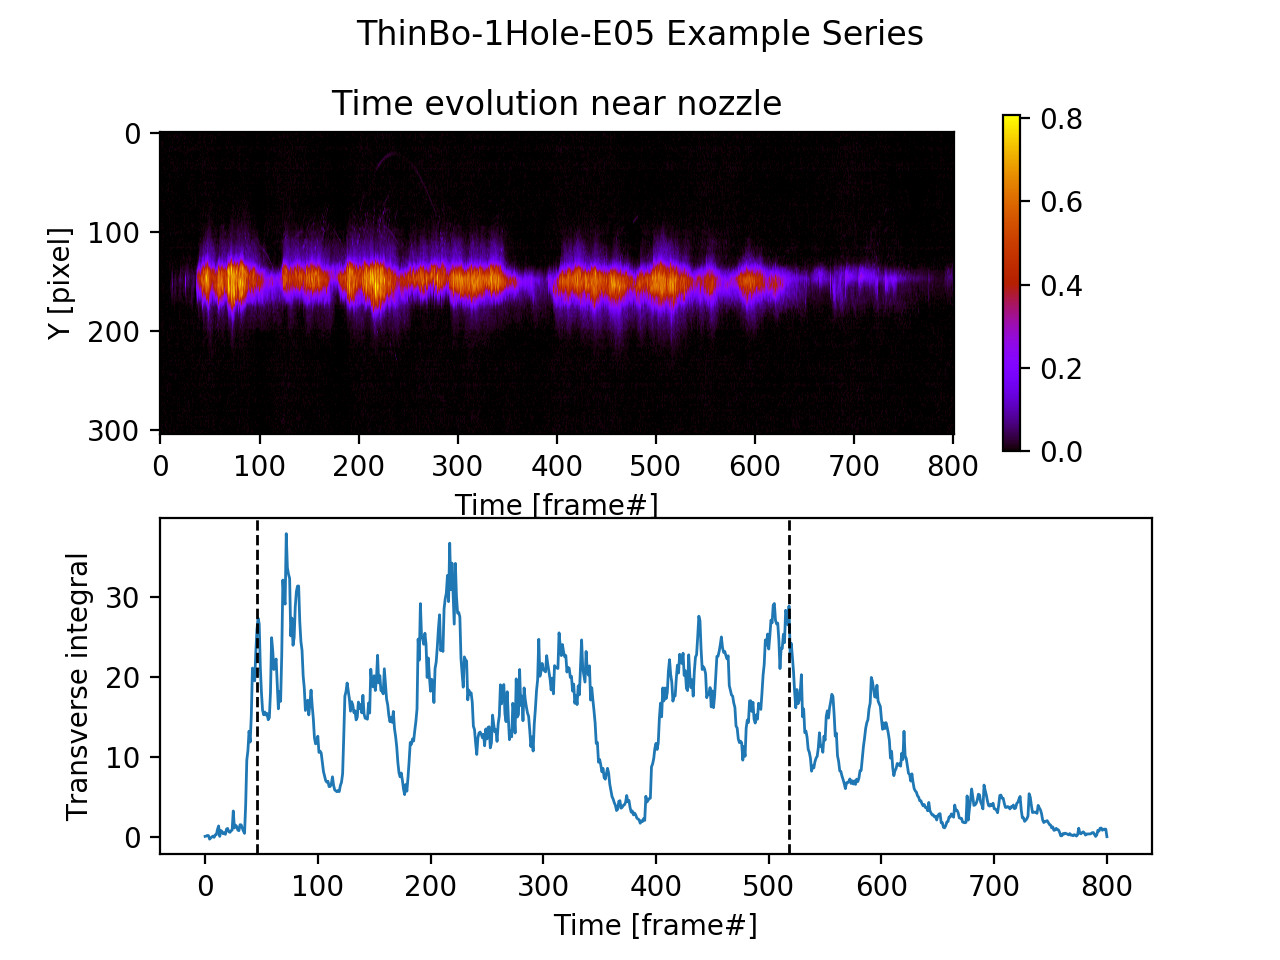

In [7]:
# Show the time evolution near the nozzle
fig=plt.figure()
plt.suptitle(os.path.basename(source_images))
ax=fig.add_subplot(211)
plt.title("Time evolution near nozzle")
plt.ylabel("Y [pixel]")
plt.xlabel("Time [frame#]")
h=ax.imshow(near_nozzle_profiles, cmap=plt.cm.gnuplot,vmin=0)
plt.colorbar(h);
ax=fig.add_subplot(212)
ax.plot(t, near_nozzle_integral, lw=1)
plt.axvline(t0,c='k',lw=1,ls='--')
plt.axvline(t1,c='k',lw=1,ls='--')
plt.ylabel("Transverse integral")
plt.xlabel("Time [frame#]");


## Obtain steady state statistics and centerline profile

In [8]:
# Take mean & std dev over "steady state" period
Im = np.nanmean(Ib[t0:t1+1],axis=0)
Is = np.nanstd(Ib[t0:t1+1],axis=0)
print("averaging over %i frames in time" % (t1-t0+1))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


averaging over 473 frames in time


/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [9]:
# Find spray centerline evaluated at two x locations with straight line
xr = 10; xl = 200
yr = np.where(Im[:,xr] == np.nanmax(Im[:,xr]))[0][0] # use max for extinction, min for transmission...
yl = np.where(Im[:,xl] == np.nanmax(Im[:,xl]))[0][0]
centerline = lambda x: x*(yl-yr)/float(xl-xr) + (yl - xl*(yl-yr)/float(xl-xr))

# Get mean and std profile interpolated along the centerline
Fint = interp2d(x,y,np.nan_to_num(Im))
mean_centerline_profile = np.array([ Fint(x_,centerline(x_)) for x_ in x ]).flatten()
Fint = interp2d(x,y,np.nan_to_num(Is))
std_centerline_profile = np.array([ Fint(x_,centerline(x_)) for x_ in x ]).flatten()

# Apply a bit of smoothing to the profiles
wl=10 # pixels
window = np.hanning(wl)
window /= scipy.integrate.simps(window)
mean_centerline_profile = np.convolve(mean_centerline_profile, window, 'same')
std_centerline_profile = np.convolve(std_centerline_profile, window, 'same')


<IPython.core.display.Javascript object>


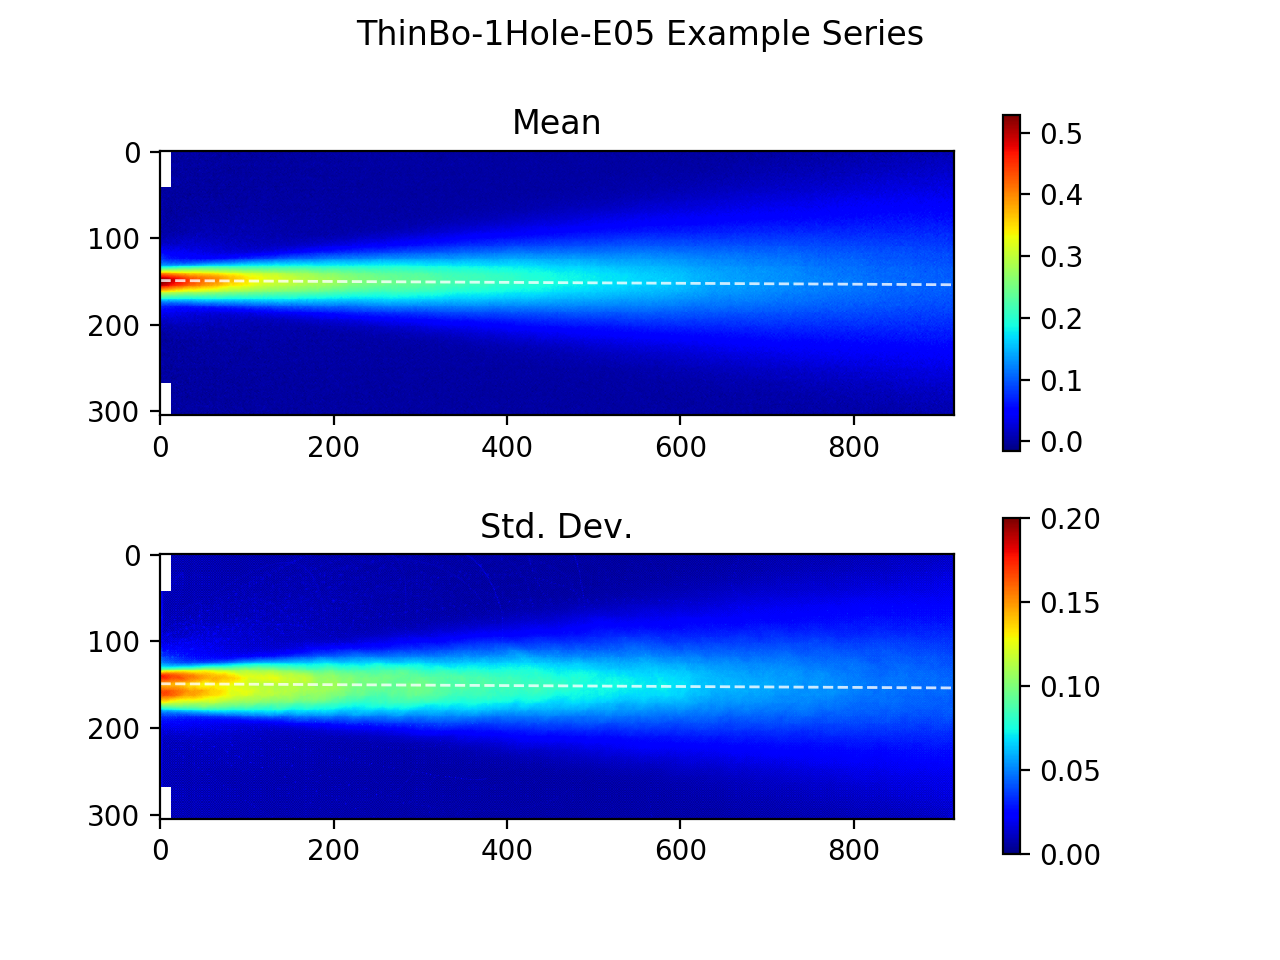

In [10]:
# Plot mean and std dev profiles
fig=plt.figure()
ax=fig.add_subplot(211)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean")
h=ax.imshow(Im,cmap=plt.cm.jet)
ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(212)
plt.title("Std. Dev.")
h=ax.imshow(Is,cmap=plt.cm.jet,vmin=0,vmax=0.2)
ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);


<IPython.core.display.Javascript object>


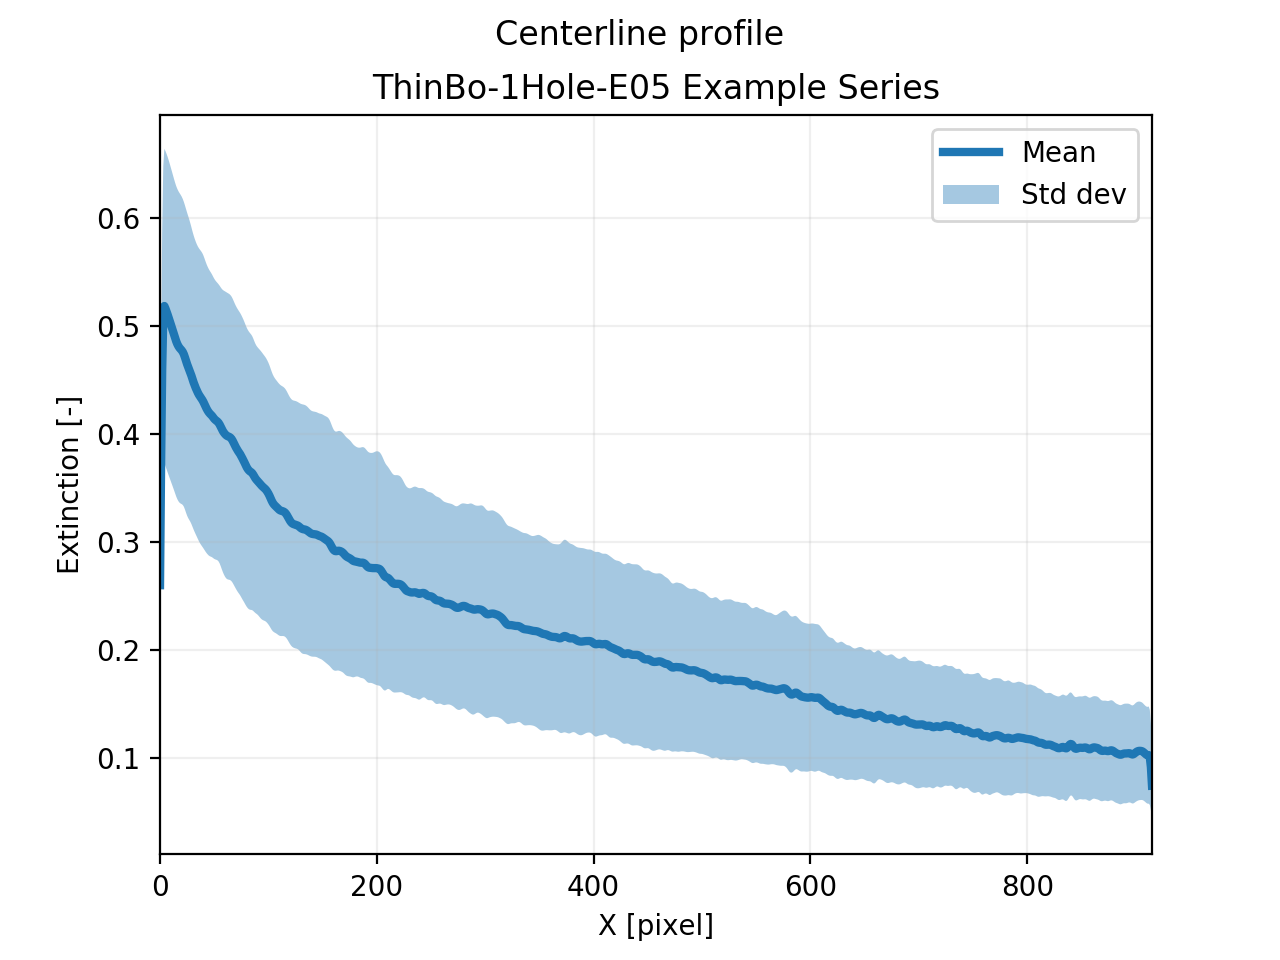

In [11]:
# Plot centerline profiles
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.2)
plt.suptitle("Centerline profile")
plt.title(os.path.basename(source_images))
plt.ylabel("Extinction [-]")
plt.xlabel("X [pixel]")
ax.plot(x,mean_centerline_profile,label='Mean',lw=3)
ax.fill_between(x,mean_centerline_profile-std_centerline_profile,\
                  mean_centerline_profile+std_centerline_profile,\
                  alpha=.4,label='Std dev')
plt.xlim(0,x.max())
plt.legend();


In [12]:
# Save the centerline profile to disk.
data = np.vstack((mean_centerline_profile, std_centerline_profile))
npz_filename = os.path.basename(source_images)+" centerline profiles.npz"
np.savez(npz_filename, data)
print("Saved",npz_filename)

Saved ThinBo-1Hole-E05 Example Series centerline profiles.npz


## Calculate a power spectrum

We will first take a transverse average since the temporal varation in $y$ is weak.
We will then take an FFT of the time record during the 'steady' period at every X.
The final result can be averaged in X for a spray-averaged spectrum.

<IPython.core.display.Javascript object>


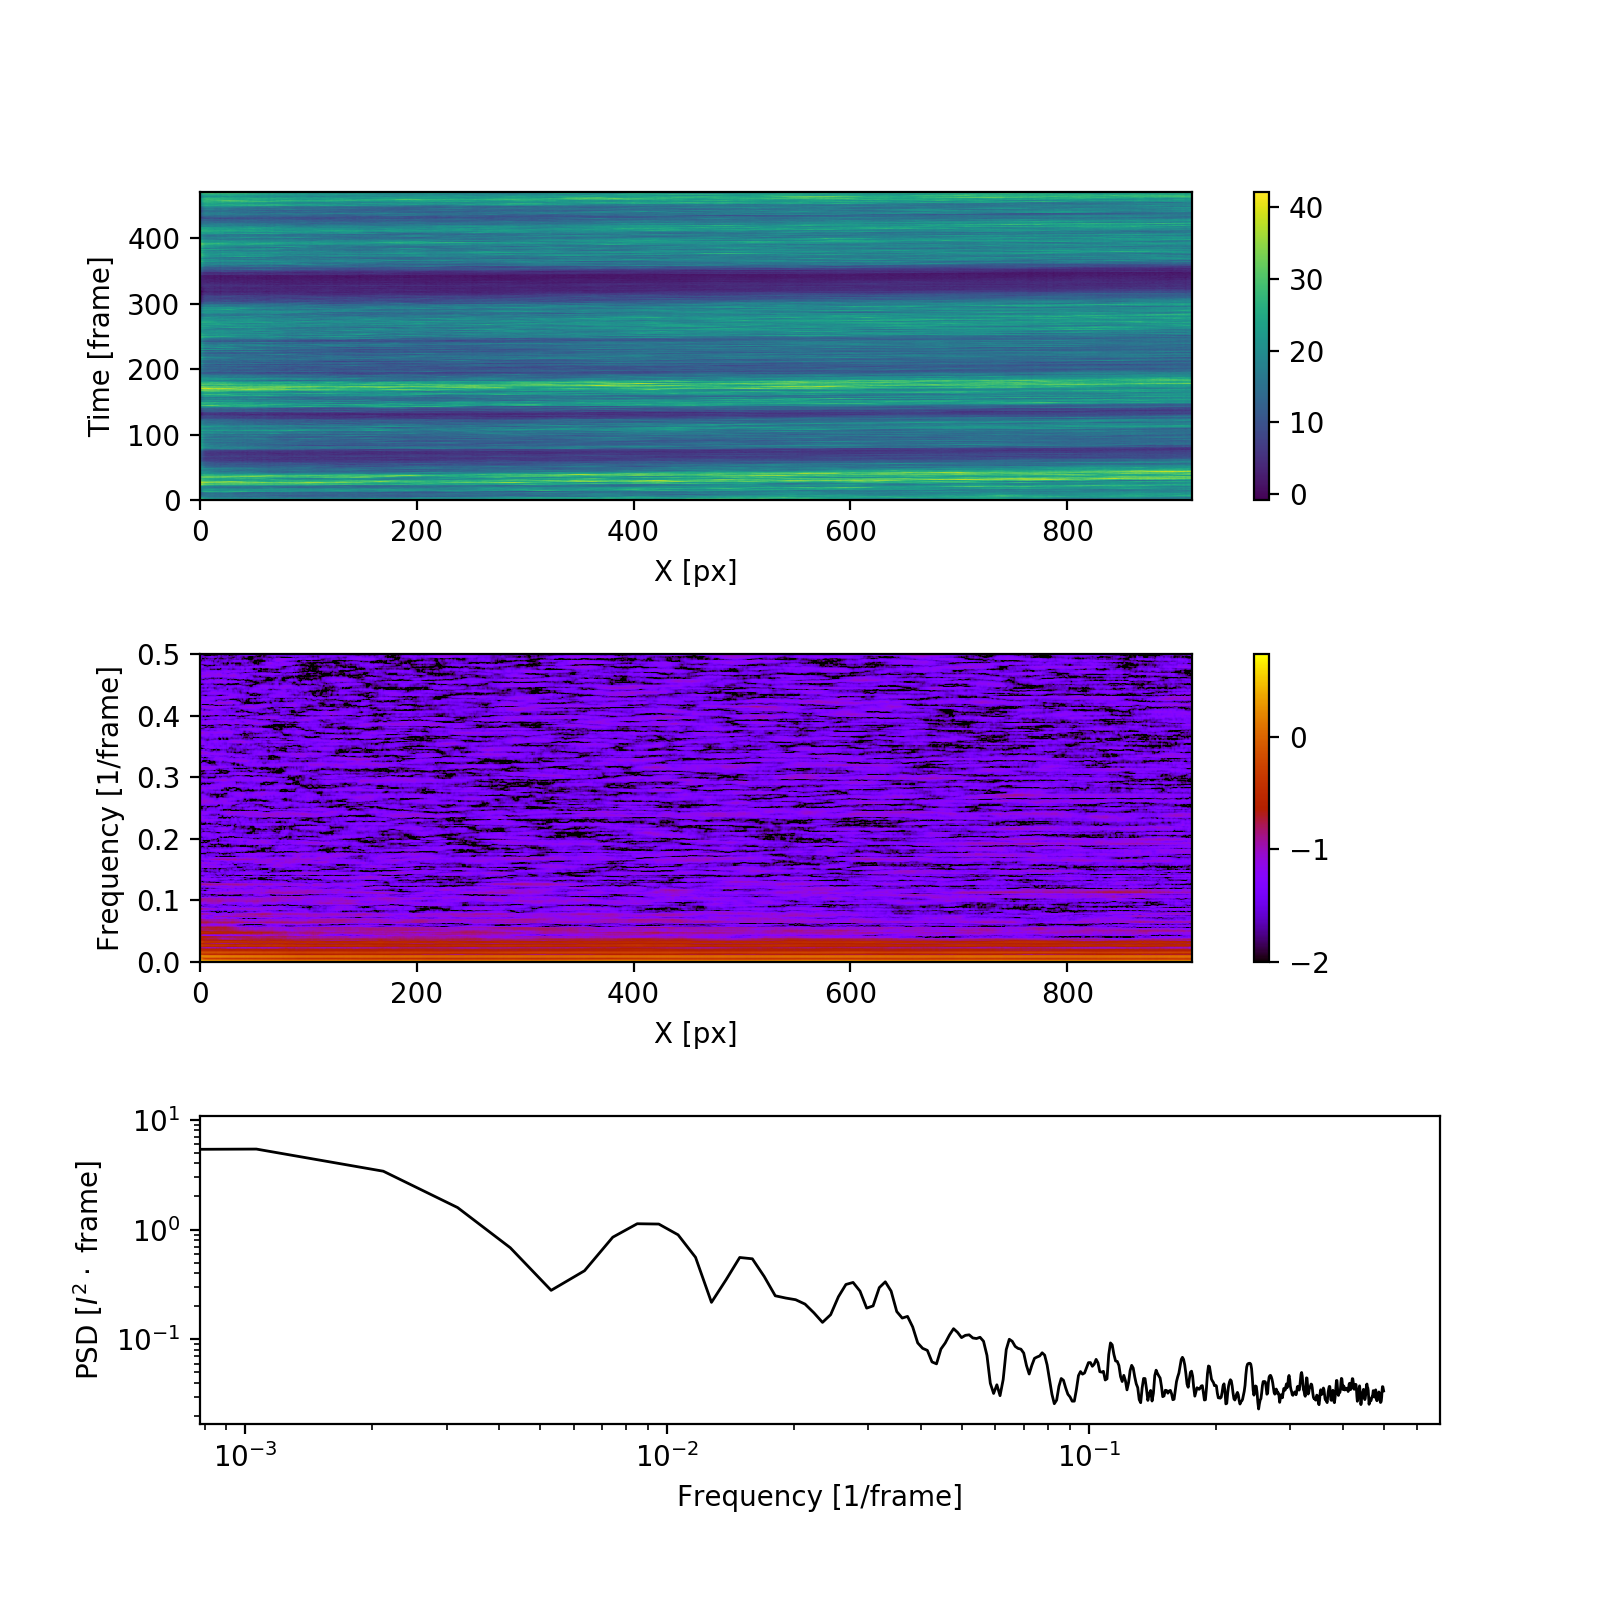

In [41]:
# Spectrum during steady state
Ib_steady = Ib[t0:t1,...] # cut out part of time domain
Ib_transv = scipy.integrate.trapz(np.nan_to_num(Ib_steady),x=y,axis=1) # integrate in y
Ib_F = np.zeros_like(Ib_transv) # make empty array
window = np.hanning(Ib_transv.shape[0])/scipy.integrate.trapz(np.hanning(Ib_transv.shape[0]))

# Set up function for one fft
def onefft(data, window):
    d = np.nan_to_num(data) # copy data
    d *= window # apply window from above
    d = np.hstack((d,np.zeros_like(d))) # zero pad.
    d -= np.mean(d) # remove mean
    F = np.abs(np.fft.fft(d))[:data.shape[0]] # one half of output.
    F /= scipy.integrate.trapz(F) # normalize
    F *= np.var(data) # make power spectral density
    F[F<=0] = 1e-20 # avoid taking log of zero
    return F

# Take spectrum over time at each X position
for i in range(Ib_F.shape[1]):
    Ib_F[:,i] = onefft(Ib_transv[:,i], window)
    
freq = np.linspace(0,0.5,Ib_F.shape[0]) # frequency axis
Ib_F_xavg = np.mean(Ib_F,axis=1) # average of all X positions.

# Take spectrum of the background reference pixel (in case light source was unsteady)
Fref = onefft(refp[t0:t1].astype(np.float)/np.nanmax(refp[t0:t1]), window)

# Take background spectrum away from the averaged spectrum
Ib_F_xavg -= Fref

# Plot transv. integrated space-time data
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(311)
xx,tt=np.meshgrid(range(Ib_transv.shape[1]),range(Ib_transv.shape[0]))
h=ax.pcolormesh(xx,tt,Ib_transv)
plt.ylabel('Time [frame]')
plt.xlabel('X [px]')
plt.colorbar(h)
# Plot fft vs X
ax=fig.add_subplot(312)
xx,ff=np.meshgrid(range(Ib_F.shape[1]),freq)
h=ax.pcolormesh(xx,ff,np.log10(Ib_F),vmin=-2,vmax=np.log10(Ib_F_xavg.max()),cmap=plt.cm.gnuplot)
plt.ylabel('Frequency [1/frame]')
plt.xlabel('X [px]')
plt.colorbar(h)
# Plot X-averaged FFT.
ax=fig.add_subplot(313)
ax.loglog(freq,Ib_F_xavg,lw=1,c='k')
ax.loglog(freq,Fref,c='b',lw=1)
plt.xlabel('Frequency [1/frame]')
plt.ylabel(r'PSD [$I^2 \cdot$ frame]')
plt.ylim(Ib_F_xavg[-1]*0.5,np.max(Ib_F_xavg)*2)
plt.subplots_adjust(hspace=.5);